In [1]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from src.data_preparation import *
from src.trainers import *
from src.testing import *
import warnings
from hydra import initialize, compose
from omegaconf import OmegaConf

warnings.filterwarnings("ignore", message=".*use_label_encoder.*")
with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name="default")

Data from all unauthorized users was used as validation data. The only difference from authorized users is that the data is normalized relative to the StandardScaler object created for the training data.

In [ ]:
all_users = cfg.all_users
main_user = cfg.main_user
scaler_path = cfg.paths.scaler
ohe_path = cfg.paths.one_hot_encoding

try:
    all_users.remove(main_user)
except ValueError:
    pass
all_users.insert(0, main_user)

raw_by_user = {}
all_action_types = set()

for user_id in all_users:
    ds_dir = os.path.join(cfg.paths.raw_data_root, "training_files", f"user{user_id}")
    df_raw = extract_features_from_dir(ds_dir, attach_filename=False)
    if df_raw.empty:
        print(f"No data for user{user_id}.")
        continue
    print(f"Extracted data for user{user_id}")
    raw_by_user[user_id] = df_raw
    all_action_types.update(df_raw['action_type'].dropna().unique().tolist())

if not raw_by_user:
    raise RuntimeError("No training/validation data.")

# Define constant OHE columns
ohe_cols = [f"action_type_{cat}" for cat in sorted(all_action_types)]
joblib.dump(ohe_cols, ohe_path)

# Fit scalera on main user
main_df_raw = raw_by_user.get(main_user)
if main_df_raw is None or main_df_raw.empty:
    raise RuntimeError("No main user data for Scaler.")

scaler = StandardScaler()
main_numeric = split_numeric(main_df_raw)
scaler.fit(main_numeric)
joblib.dump(scaler, scaler_path)

# Transform + OHE + save per user
for user_id, df_raw in raw_by_user.items():
    df_numeric = split_numeric(df_raw)
    X_scaled = pd.DataFrame(
        scaler.transform(df_numeric),
        columns=df_numeric.columns,
        index=df_numeric.index
    )
    X_ohe = ensure_ohe(df_raw['action_type'], ohe_cols)
    df_final = pd.concat([X_scaled, X_ohe], axis=1)
    joblib.dump(df_final, f"{cfg.paths.preprocessed_data}/df_user{user_id}.pkl")
    print(f"Saved df_user{user_id}.pkl  rows={len(df_final)}")

The test data is enriched with file index information and whether the session was authorized or not. The file indexes are important because the tests verified whether entire actions were authorized, as defined in the public_labels.csv file.

In [ ]:
csv_path = os.path.join(cfg.paths.raw_data_root, "public_labels.csv")
main_user = cfg.main_user
test_dir = os.path.join(cfg.paths.raw_data_root, "test_files")
scaler = joblib.load(cfg.paths.scaler)
ohe_cols = joblib.load(cfg.paths.one_hot_encoding)

labels = pd.read_csv(csv_path)
label_map = dict(zip(labels['filename'].astype(str), labels['is_illegal']))

df_test_raw = extract_features_from_dir(os.path.join(test_dir, f"user{main_user}"), attach_filename=True)
if df_test_raw.empty:
    raise RuntimeError(f"No test data in {test_dir}.")

df_test_raw['is_illegal'] = df_test_raw['__filename'].map(lambda x: label_map.get(str(x), None))
df_test_raw = df_test_raw[~df_test_raw['is_illegal'].isna()]

if df_test_raw.empty:
    raise RuntimeError("No matching labels for test files.")

test_numeric = split_numeric(df_test_raw, extra_drop_cols=['is_illegal', 'file_id', '__filename'])
X_test_scaled = pd.DataFrame(
    scaler.transform(test_numeric),
    columns=test_numeric.columns,
    index=test_numeric.index
)

X_test_ohe = ensure_ohe(df_test_raw['action_type'], ohe_cols)

df_test_final = pd.concat(
    [X_test_scaled, X_test_ohe, df_test_raw[['is_illegal', 'file_id']]],
    axis=1
)

joblib.dump(df_test_final, os.path.join(cfg.paths.preprocessed_data, f"df_user{main_user}_test.pkl"))
print(f"Saved df_user{main_user}_test.pkl  (rows={len(df_test_final)})")

## TRAINING

In [ ]:
legal_df = joblib.load(os.path.join(cfg.paths.preprocessed_data, f'df_user{cfg.main_user}.pkl'))
illegal_users = list(cfg.all_users)
illegal_users.remove(cfg.main_user)
illegal_df = pd.concat([joblib.load(os.path.join(cfg.paths.preprocessed_data, f"df_user{id}.pkl")) for id in illegal_users], ignore_index=True)

numeric_cols = [c for c in legal_df.columns if np.issubdtype(legal_df[c].dtype, np.number)]
categorical_cols = [c for c in legal_df.columns if c not in numeric_cols]

## Unsupervised

###  K-means trainer

In [ ]:
km_trainer = KMeansTrainer(
    legal_df,
    results_path=cfg.paths.K_means.all_results,
    cv_number=cfg.cv_number,
    numeric_cols=numeric_cols,
    categorical_cols=[],
)
best_score_km, best_params_km, best_model_km, best_pca_km = km_trainer.custom_grid_search(
    OmegaConf.to_container(cfg.K_means.param_grid, resolve=True)
)
save_results(
    "KMeans",
    best_params_km, best_model_km, best_pca_km,
    cfg.paths.K_means.best_results,
    cfg.paths.K_means.model,
    cfg.paths.K_means.preproc,
)

###  Isolation Forest Trainer

In [ ]:
if_trainer = IFTrainer(
    legal_df,
    results_path=cfg.paths.Isolation_forest.all_results,
    cv_number=cfg.cv_number,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
)
best_score_if, best_params_if, best_model_if, best_preproc_if = if_trainer.custom_grid_search(
    OmegaConf.to_container(cfg.Isolation_forest.param_grid, resolve=True)
)
save_results(
    "IsolationForest",
    best_params_if, best_model_if, best_preproc_if,
    cfg.paths.Isolation_forest.best_results,
    cfg.paths.Isolation_forest.model,
    cfg.paths.Isolation_forest.preproc,
)

##  Supervised

In [4]:
legal_df_sup = legal_df.copy();   legal_df_sup["label"] = 0
illegal_df_sup = illegal_df.copy(); illegal_df_sup["label"] = 1
X_sup = pd.concat([legal_df_sup, illegal_df_sup], ignore_index=True)
y_sup = X_sup["label"]; X_sup = X_sup.drop(columns=["label"])

###  XGBoost Trainer

In [ ]:
xgb_trainer = XGBoostTrainer(
    X_sup, y_sup,
    results_path=cfg.paths.XGBoost.all_results,
    cv_number=cfg.cv_number,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
)
best_score, best_params, best_model, best_preproc = xgb_trainer.custom_grid_search(
    OmegaConf.to_container(cfg.XGBoost.param_grid, resolve=True)
)
save_results(
    "XGBoost",
    best_params, best_model, best_preproc,
    cfg.paths.XGBoost.best_results,
    cfg.paths.XGBoost.model,
    cfg.paths.XGBoost.preproc,
)

###  SVM Trainer

In [ ]:
svm_trainer = SVMTrainer(
    X_sup, y_sup,
    results_path=cfg.paths.SVM.all_results,
    cv_number=cfg.cv_number,
    numeric_cols=numeric_cols,
    categorical_cols=[],
)
best_score_svm, best_params_svm, best_model_svm, best_pca_svm = svm_trainer.custom_grid_search(
    OmegaConf.to_container(cfg.SVM.param_grid, resolve=True)
)
save_results(
    "SVM",
    best_params_svm, best_model_svm, best_pca_svm,
    cfg.paths.SVM.best_results,
    cfg.paths.SVM.model,
    cfg.paths.SVM.preproc,
)

##  TESTING

In [2]:
df = joblib.load(os.path.join(cfg.paths.preprocessed_data, f'df_user{cfg.main_user}_test.pkl'))

numeric_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number) and c not in ['is_illegal', 'file_id']]
categorical_cols = [c for c in df.columns if c not in numeric_cols + ['is_illegal', 'file_id']]

df_numeric = df[numeric_cols]
df_categorical = df[categorical_cols]

is_illegal = df['is_illegal'].T
file_id = df['file_id']

###  K-means

**Per session**

c:\Users\wmaku\OneDrive\Pulpit\My_page\04_Mouse_Anomalies\.venv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\wmaku\OneDrive\Pulpit\My_page\04_Mouse_Anomalies\.venv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\wmaku\OneDrive\Pulpit\My_page\04_Mouse_Anomalies\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was 

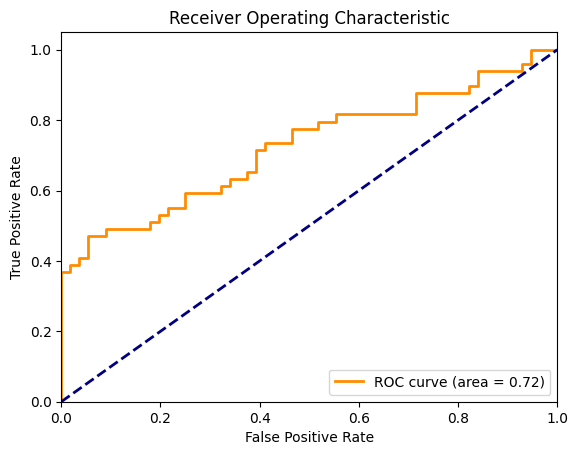

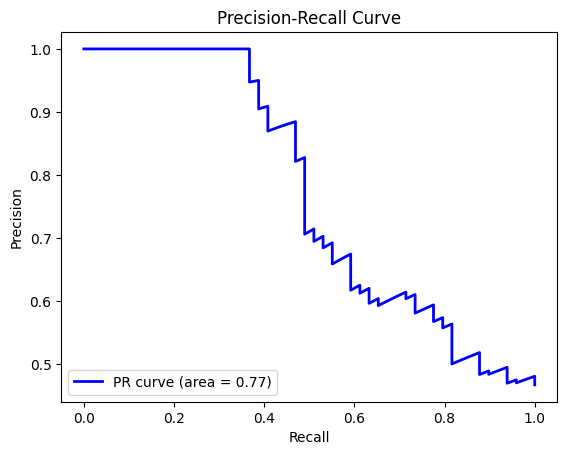

auc:  0.7248542274052477
pr auc:  0.7697116838609108
acc:  [0.5333333333333333, 0.5428571428571428, 0.7047619047619048, 0.6952380952380952, 0.7047619047619048, 0.6952380952380952, 0.7047619047619048, 0.6952380952380952, 0.7238095238095238, 0.7047619047619048, 0.7142857142857143, 0.6666666666666666, 0.6761904761904762, 0.6666666666666666, 0.6761904761904762, 0.6666666666666666, 0.6761904761904762, 0.6571428571428571, 0.6761904761904762, 0.638095238095238, 0.6476190476190476, 0.638095238095238, 0.6476190476190476, 0.6285714285714286, 0.638095238095238, 0.6285714285714286, 0.6571428571428571, 0.6476190476190476, 0.6571428571428571, 0.6285714285714286, 0.6476190476190476, 0.6190476190476191, 0.6285714285714286, 0.6095238095238096, 0.6190476190476191, 0.5333333333333333, 0.5619047619047619, 0.5047619047619047, 0.5142857142857142, 0.5047619047619047, 0.5238095238095238, 0.47619047619047616, 0.4857142857142857, 0.47619047619047616, 0.49523809523809526, 0.4666666666666667]
recalls:  [0.0, 0.02

In [6]:
estimator, preprocessed_data = read_model_preprocess_data(
    cfg.paths.K_means.model, 
    cfg.paths.K_means.preproc,
    df_numeric)

distances = estimator.transform(preprocessed_data)
scores = np.min(distances, axis=1)
scores = scores.transpose()

visualize_results(scores, file_id, is_illegal)

c:\Users\wmaku\OneDrive\Pulpit\My_page\04_Mouse_Anomalies\.venv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\wmaku\OneDrive\Pulpit\My_page\04_Mouse_Anomalies\.venv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\wmaku\OneDrive\Pulpit\My_page\04_Mouse_Anomalies\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was 

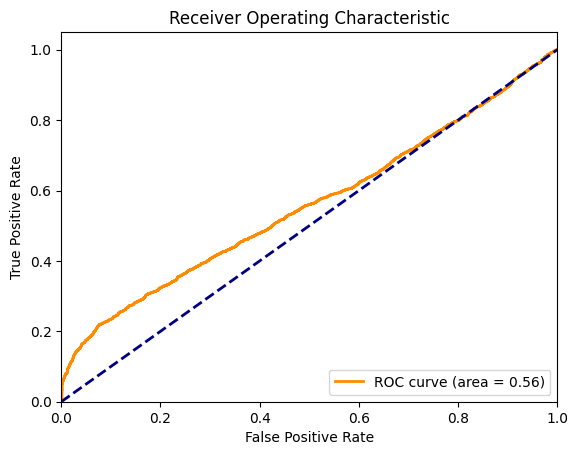

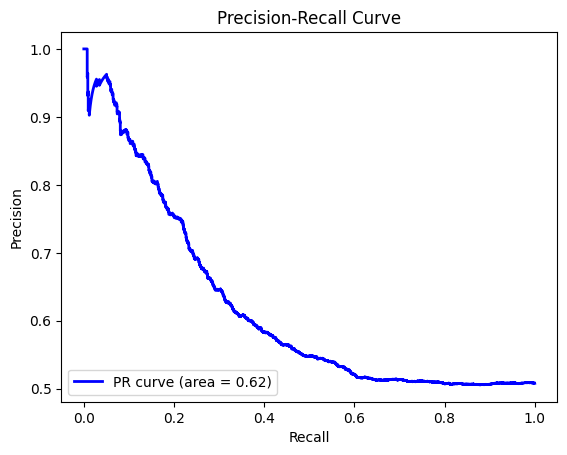

auc:  0.5581557035894935
pr auc:  0.6191613274901209


In [7]:
estimator, preprocessed_data = read_model_preprocess_data(
    cfg.paths.K_means.model,
    cfg.paths.K_means.preproc,
    df_numeric)

distances = estimator.transform(preprocessed_data)
fpr, tpr, thresholds_roc, roc_auc, precision, recall, pr_auc = validate_per_action(scores, is_illegal)

plot(fpr, tpr, roc_auc, recall, precision, pr_auc, thresholds_roc)

###  Isolation Forest

**Per session**

c:\Users\wmaku\OneDrive\Pulpit\My_page\04_Mouse_Anomalies\.venv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ExtraTreeRegressor from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\wmaku\OneDrive\Pulpit\My_page\04_Mouse_Anomalies\.venv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator IsolationForest from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


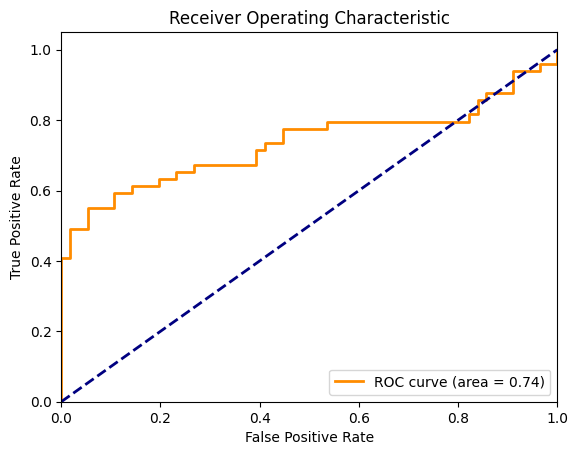

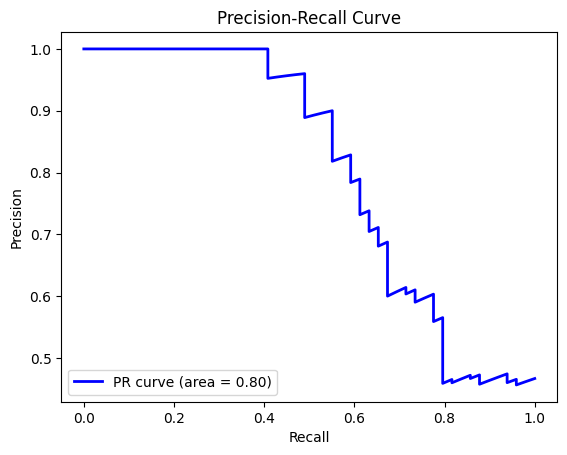

auc:  0.7354227405247813
pr auc:  0.8018995645911129
acc:  [0.5333333333333333, 0.5428571428571428, 0.7238095238095238, 0.7142857142857143, 0.7523809523809524, 0.7333333333333333, 0.7619047619047619, 0.7333333333333333, 0.7523809523809524, 0.7333333333333333, 0.7428571428571429, 0.7142857142857143, 0.7238095238095238, 0.7047619047619048, 0.7142857142857143, 0.6952380952380952, 0.7047619047619048, 0.638095238095238, 0.6571428571428571, 0.6476190476190476, 0.6571428571428571, 0.638095238095238, 0.6571428571428571, 0.6095238095238096, 0.6190476190476191, 0.4666666666666667, 0.47619047619047616, 0.4666666666666667, 0.4857142857142857, 0.47619047619047616, 0.4857142857142857, 0.45714285714285713, 0.4857142857142857, 0.45714285714285713, 0.4666666666666667, 0.44761904761904764, 0.4666666666666667]
recalls:  [0.0, 0.02040816326530612, 0.40816326530612246, 0.40816326530612246, 0.4897959183673469, 0.4897959183673469, 0.5510204081632653, 0.5510204081632653, 0.5918367346938775, 0.5918367346938775

In [8]:
estimator, preprocessed_data = read_model_preprocess_data(
    cfg.paths.Isolation_forest.model, 
    cfg.paths.Isolation_forest.preproc,
    df_numeric)

preprocessed_data = np.concatenate([preprocessed_data, df_categorical.to_numpy()], axis=1)
scores = estimator.decision_function(preprocessed_data)
scores = - scores

visualize_results(scores, file_id, is_illegal)

**Per action**

c:\Users\wmaku\OneDrive\Pulpit\My_page\04_Mouse_Anomalies\.venv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ExtraTreeRegressor from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\wmaku\OneDrive\Pulpit\My_page\04_Mouse_Anomalies\.venv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator IsolationForest from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


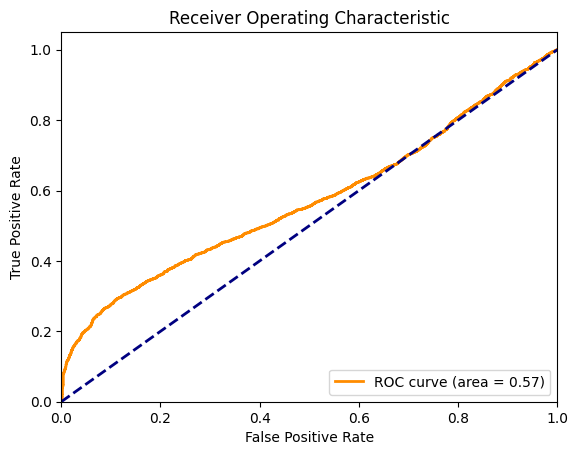

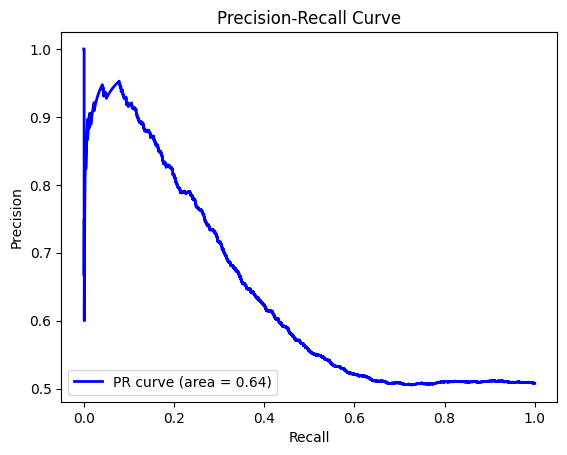

auc:  0.5714617912106497
pr auc:  0.6387549597138715


In [13]:
estimator, preprocessed_data = read_model_preprocess_data(
    cfg.paths.Isolation_forest.model,
    cfg.paths.Isolation_forest.preproc,
    df_numeric)

preprocessed_data = np.concatenate([preprocessed_data, df_categorical.to_numpy()], axis=1)
scores = estimator.decision_function(preprocessed_data)
scores = - scores

fpr, tpr, thresholds_roc, roc_auc, precision, recall, pr_auc = validate_per_action(scores, is_illegal)

plot(fpr, tpr, roc_auc, recall, precision, pr_auc, thresholds_roc)

### XGBoost

**Per session**

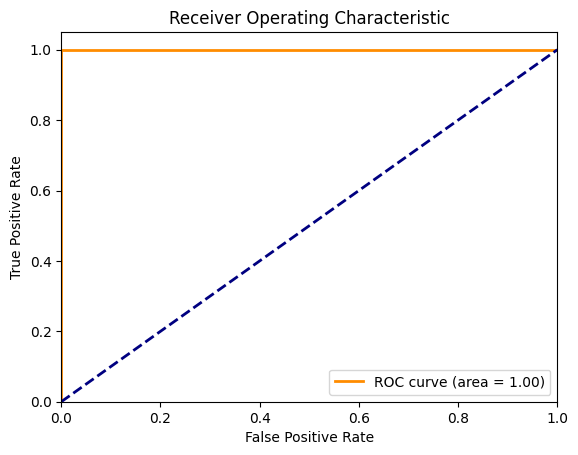

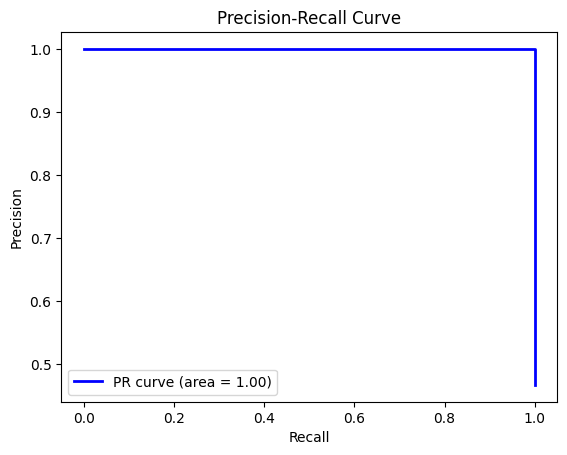

auc:  1.0
pr auc:  1.0
acc:  [0.5333333333333333, 0.5428571428571428, 1.0, 0.4666666666666667]
recalls:  [0.0, 0.02040816326530612, 1.0, 1.0]


In [3]:
estimator, preprocessed_data = read_model_preprocess_data(
    cfg.paths.XGBoost.model, 
    cfg.paths.XGBoost.preproc,
    df_numeric)

preprocessed_data = np.concatenate([preprocessed_data, df_categorical.to_numpy()], axis=1)
scores = estimator.predict_proba(preprocessed_data[:, ])[:, 1]
visualize_results(scores, file_id, is_illegal)

**Per action**

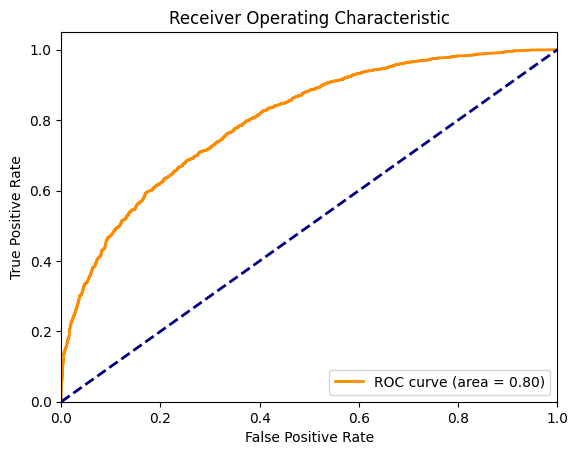

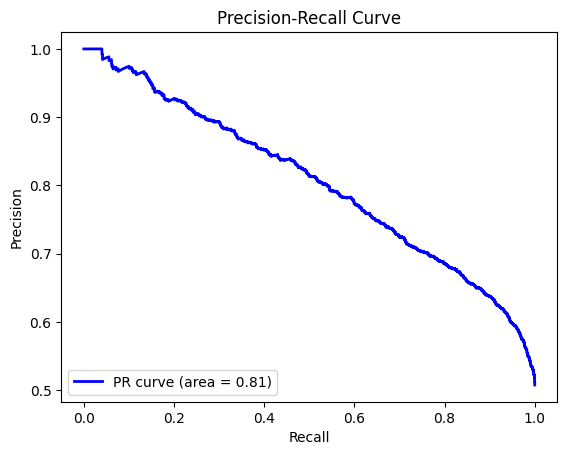

auc:  0.7989798506921795
pr auc:  0.8052481787758099


In [4]:
estimator, preprocessed_data = read_model_preprocess_data(
    cfg.paths.XGBoost.model, 
    cfg.paths.XGBoost.preproc,
    df_numeric)

preprocessed_data = np.concatenate([preprocessed_data, df_categorical.to_numpy()], axis=1)
scores = estimator.predict_proba(preprocessed_data)[:, 1]
fpr, tpr, thresholds_roc, roc_auc, precision, recall, pr_auc = validate_per_action(scores, is_illegal)

plot(fpr, tpr, roc_auc, recall, precision, pr_auc, thresholds_roc)

###  SVM

**Per session**

c:\Users\wmaku\OneDrive\Pulpit\My_page\04_Mouse_Anomalies\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


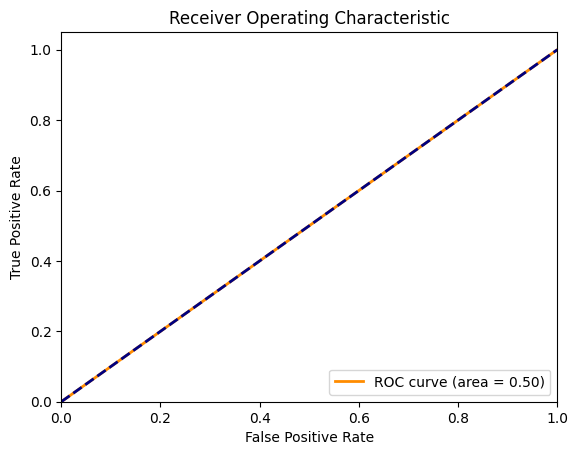

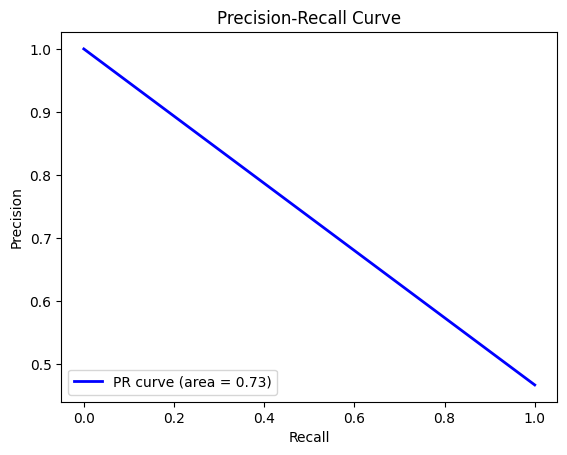

auc:  0.5
pr auc:  0.7333333333333334
acc:  [0.5333333333333333, 0.4666666666666667]
recalls:  [0.0, 1.0]


In [15]:
estimator, preprocessed_data = read_model_preprocess_data(
    cfg.paths.SVM.model, 
    cfg.paths.SVM.preproc,
    df_numeric)

scores = estimator.decision_function(preprocessed_data)
visualize_results(scores, file_id, is_illegal)

c:\Users\wmaku\OneDrive\Pulpit\My_page\04_Mouse_Anomalies\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


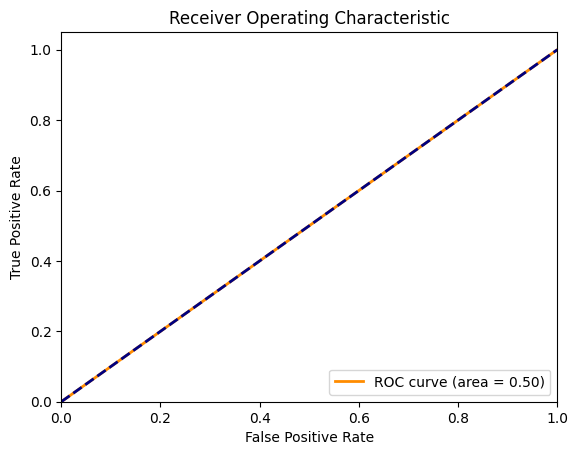

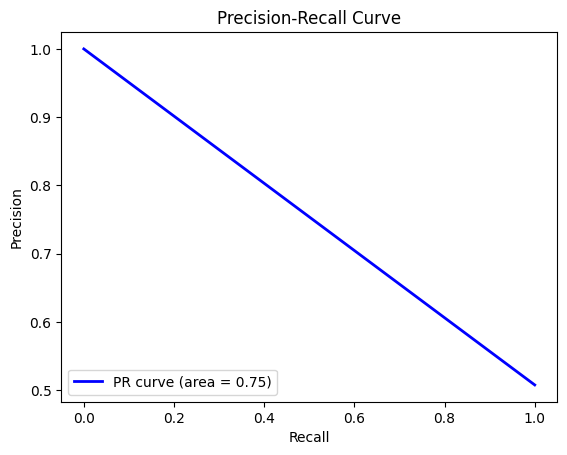

auc:  0.5
pr auc:  0.7539761431411531


In [7]:
estimator, preprocessed_data = read_model_preprocess_data(
    cfg.paths.SVM.model, 
    cfg.paths.SVM.preproc,
    df_numeric)

scores = estimator.decision_function(preprocessed_data)
fpr, tpr, thresholds_roc, roc_auc, precision, recall, pr_auc = validate_per_action(scores, is_illegal)
plot(fpr, tpr, roc_auc, recall, precision, pr_auc, thresholds_roc)

An ROC-AUC of 0.5 corresponds to random guessing, which initially raised concerns that there might be an error in the implementation or that the model was not learning at all. To verify this, training was repeated for user7, where the ROC-AUC reached 1.0 per session and 0.77 per action. This confirmed that the code and model were functioning correctly, but also indicated that SVM requires very specific data to achieve high effectiveness.

### Best parameters

```json
K-means:
{
    "alpha": 0.2,
    "n_clusters": 2,
    "n_components": 15,
}

Isolation_forest:
{
    "alpha": 0.2,
    "bootstrap": true,
    "max_features": 1.0,
    "max_samples": 0.1,
    "n_components": null,
    "n_estimators": 64
}

XGBoost:
{
    "balancing": "proportional",
    "learning_rate": 0.1,
    "max_depth": 9,
    "max_leaves": 32,
    "n_components": null,
    "n_estimators": 200
}

SVM:
{
    None #Results mostly close to random on tested data
}
```

## Conclusions
- Both unsupervised methods (K-means, Isolation Forest) were useful for anomaly detection, especially at the session level. However, classification per action showed very low precision, which confirms that more aggregated data is necessary to obtain stable performance.
- XGBoost consistently achieved very high AUC values. While initially surprising, these results are consistent with [https://arxiv.org/pdf/1810.04668] and can be explained by the model’s supervised nature, ability to handle categorical features, and capacity to capture non-linear relationships. In this context, the performance is credible rather than suspicious.
- SVM generally struggled to capture the structure of the data, even when kernel functions were applied. In some cases (e.g., user7) results were better, which suggests that the method may occasionally align with a particular user’s data distribution. Overall, however, SVM proved unstable and less effective compared to other approaches.
- The combination of PCA with K-means preprocessing produced the most consistent results for SVM. This indicates that PCA successfully reduced noise and helped the K-means extract more usable information.
- For XGBoost, proportional balancing provided better results than SMOTE, suggesting that proportional resampling better preserved the natural structure of the dataset.
- It is important to note that PR AUC values are not centered around 0.5 as in ROC, but instead depend on the proportion of positive samples in the dataset. For example, when positives account for ~75% of the data, even a random classifier will yield a PR AUC of about 0.75. This explains why high PR AUC values may appear alongside low ROC AUC values.